* has the architecture to C1C2C3C40 (No MaxPooling, but 3 convolutions, where the last one has a stride of 2 instead) (If you can figure out how to use Dilated kernels here instead of MP or strided convolution, then 200pts extra!)
* total RF must be more than 44
* one of the layers must use Depthwise Separable Convolution
* one of the layers must use Dilated Convolution
* use GAP (compulsory):- add FC after GAP to target #of classes (optional)
* use albumentation library and apply:
* horizontal flip
* shiftScaleRotate
* coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
* achieve 85% accuracy, as many epochs as you want. Total Params to be less than 200k.
* make sure you're following code-modularity (else 0 for full assignment) 

In this notebook we will try using albumentations library for data augmentation.

In [1]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
# !pip install portalocker
# !pip install torchview
# !pip install torcheval
# !pip install scikit-plot

## Helpers and Utils

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy, BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import (
    ReduceLROnPlateau,
    StepLR,
    OneCycleLR,
    ExponentialLR,
)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
import seaborn as sns
import torch.nn.functional as F
import albumentations as alb
from albumentations.pytorch import ToTensorV2
import cv2

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
def plot_loss_accuracy(
    train_loss,
    val_loss,
    train_acc,
    val_acc,
    labels,
    colors,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    legend_font=5,
    fig_size=(16, 10),
    sub_plot1=(1, 2, 1),
    sub_plot2=(1, 2, 2),
):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure

    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(
            x_train,
            train_loss[i],
            linestyle="-",
            color="tab:{}".format(colors[i]),
            label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]),
        )
        plt.plot(
            x_val,
            val_loss[i],
            linestyle="--",
            color="tab:{}".format(colors[i]),
            label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]),
        )

    plt.xlabel("epoch no.")
    plt.ylabel("loss")
    plt.legend(loc=loss_legend_loc, prop={"size": legend_font})
    plt.title("Training and Validation Loss")

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(
            x_train,
            train_acc[i],
            linestyle="-",
            color="tab:{}".format(colors[i]),
            label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]),
        )
        plt.plot(
            x_val,
            val_acc[i],
            linestyle="--",
            color="tab:{}".format(colors[i]),
            label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]),
        )

    plt.xlabel("epoch no.")
    plt.ylabel("accuracy")
    plt.legend(loc=acc_legend_loc, prop={"size": legend_font})
    plt.title("Training and Validation Accuracy")

    plt.show()

In [6]:
# decorator function to record time exp
from functools import wraps
import time


def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f"Function Took {total_time:.4f} seconds")
        return result

    return timeit_wrapper

In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 128
epochs = 20
lr = 1e-3

Random seed set as 42
cuda


In [8]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=3, verbose=True, delta=1e-5, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = "checkpoint.pt"
        self.trace_func = trace_func

    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Dataloader and pre-processing using torchvision tansforms

#### Use of albumentations

In [9]:
# transform for the dataset using Compose from albumentations
train_transforms = alb.Compose(
    [
        alb.HorizontalFlip(),
        alb.ShiftScaleRotate(),
        alb.ColorJitter(),
        alb.CoarseDropout(
            max_holes=1,
            max_height=16,
            max_width=16,
            min_holes=1,
            min_height=16,
            min_width=16,
            fill_value=[0.4914, 0.4822, 0.4465],
            mask_fill_value=None,
        ),
        alb.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

test_transforms = alb.Compose(
    [
        alb.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

In [10]:
# downloading train and test data
train = datasets.CIFAR10("./data", train=True, download=True)
test = datasets.CIFAR10("./data", train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# for X, y in train:
#     print(X)
#     print(y)
#     print(type(X))
#     break

In [12]:
class CifarDS(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [13]:
train_dateset  = CifarDS(train.data, train.targets, train_transforms)
test_dateset = CifarDS(test.data, test.targets, test_transforms)

In [14]:
for data,label in train_dateset:
    print(data.shape)
    print(label)
    print(data.mean())
    break

torch.Size([3, 32, 32])
6
tensor(-0.4074)


In [15]:
# Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = (
    dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
    if device.type == "cuda"
    else dict(shuffle=True, batch_size=64)
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_dateset, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_dateset, **dataloader_args)

In [16]:
# Specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [17]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([128, 3, 32, 32])
torch.Size([128])


In [18]:
# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

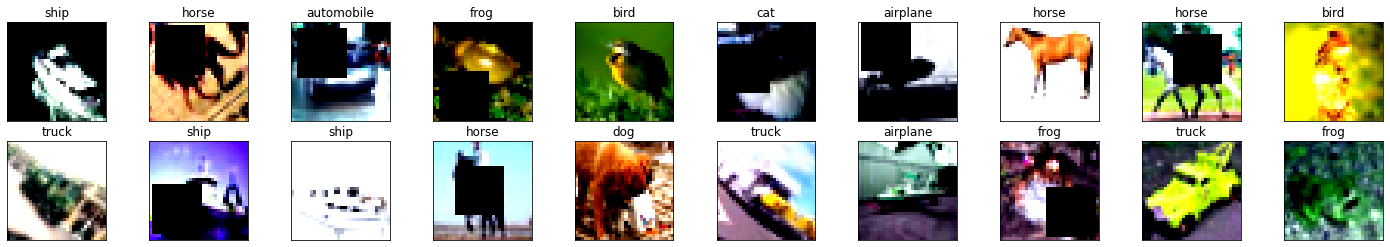

In [19]:
# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Model Building 1 - Using only dialated convolutions

In [20]:
# updated training module---
@timeit
def train_module(
    model: torch.nn.Module,
    device: torch.device,
    train_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    metric,
    train_losses: list,
    train_metrics: list,
):

    # setting model to train mode
    model.train()
    pbar = tqdm(train_dataloader)

    # batch metrics
    train_loss = 0
    train_metric = 0
    processed_batch = 0

    for idx, (data, label) in enumerate(pbar):
        # setting up device
        data = data.to(device)
        label = label.to(device)

        # forward pass output
        preds = model(data)

        # calc loss
        loss = criterion(preds, label)
        train_loss += loss.item()
        # print(f"training loss for batch {idx} is {loss}")

        # backpropagation
        optimizer.zero_grad()  # flush out  existing grads
        loss.backward()  # back prop of weights wrt loss
        optimizer.step()  # optimizer step -> minima

        # metric calc
        preds = torch.argmax(preds, dim=1)
        # print(f"preds:: {preds}")
        metric.update(preds, label)
        train_metric += metric.compute().detach().item()

        # updating batch count
        processed_batch += 1

        pbar.set_description(
            f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}"
        )

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    train_losses.append(train_loss / processed_batch)
    train_metrics.append(train_metric / processed_batch)

    return train_losses, train_metrics

In [21]:
# updated testing modules---
@timeit
def test_module(
    model: torch.nn.Module,
    device: torch.device,
    test_dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    metric,
    test_losses,
    test_metrics,
):
    # setting model to eval mode
    model.eval()
    pbar = tqdm(test_dataloader)

    # batch metrics
    test_loss = 0
    test_metric = 0
    processed_batch = 0

    with torch.inference_mode():
        for idx, (data, label) in enumerate(pbar):
            data, label = data.to(device), label.to(device)
            # predictions
            preds = model(data)
            # print(preds.shape)
            # print(label.shape)

            # loss calc
            loss = criterion(preds, label)
            test_loss += loss.item()

            # metric calc
            preds = torch.argmax(preds, dim=1)
            metric.update(preds, label)
            test_metric += metric.compute().detach().item()

            # updating batch count
            processed_batch += 1

            pbar.set_description(
                f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}"
            )

        # It's typically called after the epoch completes
        metric.reset()
        # updating epoch metrics
        test_losses.append(test_loss / processed_batch)
        test_metrics.append(test_metric / processed_batch)

    return test_losses, test_metrics

In [22]:
class DialatedClassificationTransition(nn.Module):
    ''' This class is used to create a model with dialated convolution and transition block for CIFAR10 dataset'''
    def __init__(
        self,
        in_channels,
        hidden_units,
        out_channels,
        multiplier_1=1,
        multiplier_2=2,
        dropout=0.1,
    ):
        super(DialatedClassificationTransition, self).__init__()
        # block1
        self.conv_bl1 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
        )
        # transition block
        self.transition = nn.Sequential(
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=hidden_units,
                kernel_size=(1, 1),
                padding=0,
                bias=False,
            ),
        )
        # block2
        self.conv_bl2 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=(hidden_units),
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
        )
        # block3
        self.conv_bl3 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=(hidden_units),
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
        )
        # block4
        self.conv_bl4 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=(hidden_units),
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=out_channels,
                kernel_size=(1, 1),
                padding=0,
                bias=False,
            )
        )

    def forward(self, x):
        x = self.conv_bl1(x)
        x = self.transition(x)
        x = self.conv_bl2(x)
        x = self.transition(x)
        x = self.conv_bl3(x)
        x = self.transition(x)
        x = self.conv_bl4(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [23]:
# New Model Instance
dilated_model1 = DialatedClassificationTransition(
    in_channels=3, hidden_units=16, out_channels=10, multiplier_1=2, multiplier_2=4
).to(device)
summary(dilated_model1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 30, 30]          36,864
             ReLU-10           [-1, 64, 30, 30]               0
      BatchNorm2d-11           [-1, 64, 30, 30]             128
          Dropout-12           [-1, 64, 30, 30]               0
           Conv2d-13           [-1, 16, 30, 30]           1,024
           Conv2d-14           [-1, 32,

In [24]:
# driver setup----
# optmizer
optimizer = optim.Adam(dilated_model1.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device=device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)
# lr scheduler
lr_scheduler = ExponentialLR(optimizer, gamma=0.97)

In [25]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs+10):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        dilated_model1,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        dilated_model1,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )

    lr_scheduler.step()  # lr scheduler stepping
    print(f"For next epoch lr:: {lr_scheduler.get_last_lr()[0]}")
    early_stopping(
        test_losses[-1], dilated_model1, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


Avg Train Loss: 1.7457436478656272 Avg Train Metric: 0.28709964073070177: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00, 10.02it/s]


Function Took 39.0534 seconds


Avg Test Loss: 1.3649038408375993 Avg Test Metric: 0.49583710824386984: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.12it/s]


Function Took 2.6271 seconds
For next epoch lr:: 0.00099
Validation loss decreased (inf --> 1.364904).  Saving model ...
Epoch 1


Avg Train Loss: 1.486126751850938 Avg Train Metric: 0.4368234420828807: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.11it/s]


Function Took 38.6960 seconds


Avg Test Loss: 1.2832314590864544 Avg Test Metric: 0.5257025783575033: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.42it/s]


Function Took 2.6892 seconds
For next epoch lr:: 0.0009801
Validation loss decreased (1.364904 --> 1.283231).  Saving model ...
Epoch 2


Avg Train Loss: 1.3571024950203079 Avg Train Metric: 0.49426702991166077: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.21it/s]


Function Took 38.2962 seconds


Avg Test Loss: 1.1722647849517533 Avg Test Metric: 0.5900740495210961: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.46it/s]


Function Took 2.5146 seconds
For next epoch lr:: 0.000970299
Validation loss decreased (1.283231 --> 1.172265).  Saving model ...
Epoch 3


Avg Train Loss: 1.2648291542097125 Avg Train Metric: 0.5380911994773103: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.27it/s]


Function Took 38.0804 seconds


Avg Test Loss: 0.9902620836149288 Avg Test Metric: 0.6470257262640362: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.98it/s]


Function Took 2.5538 seconds
For next epoch lr:: 0.0009605960099999999
Validation loss decreased (1.172265 --> 0.990262).  Saving model ...
Epoch 4


Avg Train Loss: 1.200032025194534 Avg Train Metric: 0.5648954089950112: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.24it/s]


Function Took 38.1955 seconds


Avg Test Loss: 0.964885759957229 Avg Test Metric: 0.6535179924361313: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.96it/s]


Function Took 2.5561 seconds
For next epoch lr:: 0.0009509900498999999
Validation loss decreased (0.990262 --> 0.964886).  Saving model ...
Epoch 5


Avg Train Loss: 1.1422358191836521 Avg Train Metric: 0.5891614672168136: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.21it/s]


Function Took 38.3201 seconds


Avg Test Loss: 0.8757883740376823 Avg Test Metric: 0.6953249339815937: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.47it/s]


Function Took 2.5971 seconds
For next epoch lr:: 0.0009414801494009999
Validation loss decreased (0.964886 --> 0.875788).  Saving model ...
Epoch 6


Avg Train Loss: 1.0981866401784561 Avg Train Metric: 0.6120574898122216: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.20it/s]


Function Took 38.3189 seconds


Avg Test Loss: 0.8450707182099547 Avg Test Metric: 0.7200515609753283: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.78it/s]


Function Took 2.5707 seconds
For next epoch lr:: 0.0009320653479069899
Validation loss decreased (0.875788 --> 0.845071).  Saving model ...
Epoch 7


Avg Train Loss: 1.0561137354892234 Avg Train Metric: 0.6237643652254968: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.22it/s]


Function Took 38.2671 seconds


Avg Test Loss: 0.7845943875705139 Avg Test Metric: 0.7356295374375356: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.35it/s]


Function Took 2.5250 seconds
For next epoch lr:: 0.00092274469442792
Validation loss decreased (0.845071 --> 0.784594).  Saving model ...
Epoch 8


Avg Train Loss: 1.0296401695522202 Avg Train Metric: 0.6321677260691553: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.13it/s]


Function Took 38.5877 seconds


Avg Test Loss: 0.7485596907289722 Avg Test Metric: 0.7456902167465114: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.41it/s]


Function Took 2.5196 seconds
For next epoch lr:: 0.0009135172474836408
Validation loss decreased (0.784594 --> 0.748560).  Saving model ...
Epoch 9


Avg Train Loss: 1.0099798982100718 Avg Train Metric: 0.6447438178464885: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.14it/s]


Function Took 38.5483 seconds


Avg Test Loss: 0.7168309462221363 Avg Test Metric: 0.7539712152903593: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.82it/s]


Function Took 2.4867 seconds
For next epoch lr:: 0.0009043820750088043
Validation loss decreased (0.748560 --> 0.716831).  Saving model ...
Epoch 10


Avg Train Loss: 0.9820454587107119 Avg Train Metric: 0.6501975405551589: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.22it/s]


Function Took 38.2692 seconds


Avg Test Loss: 0.7201166594330268 Avg Test Metric: 0.7589646894720536: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.24it/s]


Function Took 2.5331 seconds
For next epoch lr:: 0.0008953382542587163
EarlyStopping counter: 1 out of 3
Epoch 11


Avg Train Loss: 0.9596012652377643 Avg Train Metric: 0.660853263514731: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.25it/s]


Function Took 38.1585 seconds


Avg Test Loss: 0.6933198601384706 Avg Test Metric: 0.7647508797766287: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.14it/s]


Function Took 2.5410 seconds
For next epoch lr:: 0.0008863848717161291
Validation loss decreased (0.716831 --> 0.693320).  Saving model ...
Epoch 12


Avg Train Loss: 0.9457923573301271 Avg Train Metric: 0.6671797366398374: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.14it/s]


Function Took 38.5497 seconds


Avg Test Loss: 0.6667061591450172 Avg Test Metric: 0.7715633006035527: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.89it/s]


Function Took 2.5616 seconds
For next epoch lr:: 0.0008775210229989678
Validation loss decreased (0.693320 --> 0.666706).  Saving model ...
Epoch 13


Avg Train Loss: 0.9198698884690814 Avg Train Metric: 0.6752243688344346: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.23it/s]


Function Took 38.2431 seconds


Avg Test Loss: 0.6366297945946078 Avg Test Metric: 0.7777411243583583: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.21it/s]


Function Took 2.6186 seconds
For next epoch lr:: 0.0008687458127689781
Validation loss decreased (0.666706 --> 0.636630).  Saving model ...
Epoch 14


Avg Train Loss: 0.9178921386713872 Avg Train Metric: 0.6768288688586496: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.20it/s]


Function Took 38.3308 seconds


Avg Test Loss: 0.6428232928620109 Avg Test Metric: 0.7776041875911665: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.63it/s]


Function Took 2.5833 seconds
For next epoch lr:: 0.0008600583546412883
EarlyStopping counter: 1 out of 3
Epoch 15


Avg Train Loss: 0.8983070928117504 Avg Train Metric: 0.6853698813701834: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.23it/s]


Function Took 38.2365 seconds


Avg Test Loss: 0.6030939645782302 Avg Test Metric: 0.7958779599093184: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.64it/s]


Function Took 2.5012 seconds
For next epoch lr:: 0.0008514577710948754
Validation loss decreased (0.636630 --> 0.603094).  Saving model ...
Epoch 16


Avg Train Loss: 0.8872644594868125 Avg Train Metric: 0.6914737873979847: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.16it/s]


Function Took 38.4950 seconds


Avg Test Loss: 0.6342103764226165 Avg Test Metric: 0.7848212711418732: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.67it/s]


Function Took 2.4981 seconds
For next epoch lr:: 0.0008429431933839266
EarlyStopping counter: 1 out of 3
Epoch 17


Avg Train Loss: 0.8752909926197413 Avg Train Metric: 0.6924209541372021: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.26it/s]


Function Took 38.1165 seconds


Avg Test Loss: 0.6113541299783731 Avg Test Metric: 0.7910475866704048: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.53it/s]


Function Took 2.5097 seconds
For next epoch lr:: 0.0008345137614500873
EarlyStopping counter: 2 out of 3
Epoch 18


Avg Train Loss: 0.8626128476294105 Avg Train Metric: 0.6975017965907027: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.29it/s]


Function Took 37.9965 seconds


Avg Test Loss: 0.6204403555845912 Avg Test Metric: 0.7919705396966089: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.51it/s]

Function Took 2.5935 seconds
For next epoch lr:: 0.0008261686238355864
EarlyStopping counter: 3 out of 3
Early stopping


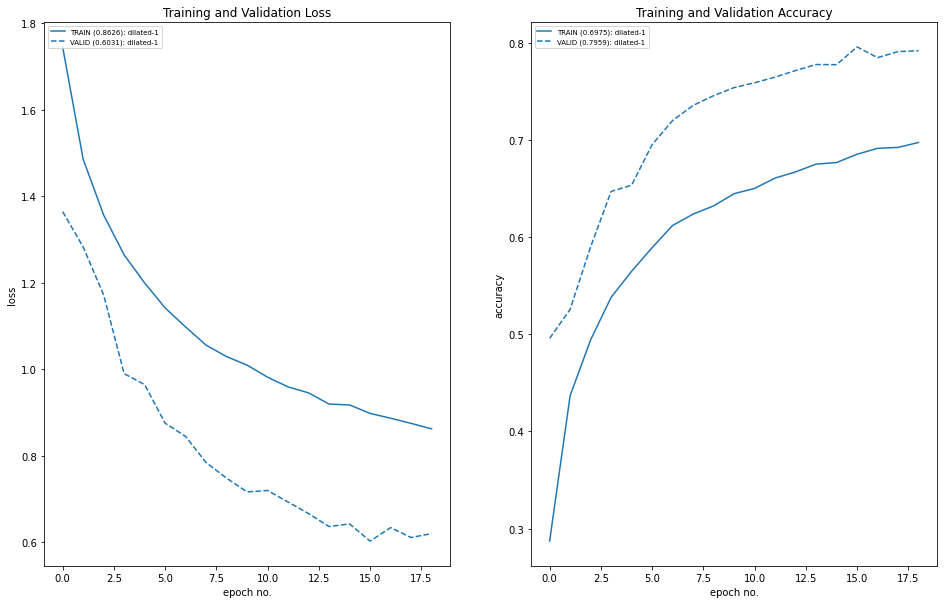

In [26]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["dilated-1"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

## Model Building 2- Depthwise Separable Convolution with Transition Block

In [31]:
class DepthwiseSeparableClassifierSync(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_units,
        out_channels,
        dropout=0.1,
    ):
        super(DepthwiseSeparableClassifierSync, self).__init__()
        # block1
        self.conv_bl1 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(2 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=2 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=4 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4 * hidden_units),
            nn.Dropout(dropout),
        )
        # transition block
        self.transition = nn.Sequential(
            nn.Conv2d(
                in_channels=4 * hidden_units,
                out_channels=hidden_units,
                kernel_size=(1, 1),
                padding=0,
                bias=False,
            ),
        )
        # block2
        self.conv_bl2 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(2 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=2 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=4 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4 * hidden_units),
            nn.Dropout(dropout),
        )
        # block3
        self.conv_bl3 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(2 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=2 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=4 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4 * hidden_units),
            nn.Dropout(dropout),
        )
        # block4 - Depthwise Separable Convolution **
        self.conv_bl4 = nn.Sequential(
            # set1
            # depthwise
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
                groups=hidden_units,
            ),
            # pointwise
            nn.Conv2d(
                in_channels=2 * hidden_units,
                out_channels=2 * hidden_units,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(2 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            # depthwise
            nn.Conv2d(
                in_channels=(2 * hidden_units),
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
                groups=2 * hidden_units,
            ),
            # pointwise
            nn.Conv2d(
                in_channels=4 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(4 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set3 -non-dialation - depthwise
            # depthwise
            nn.Conv2d(
                in_channels=(4 * hidden_units),
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
                groups=4 * hidden_units,
            ),
            # pointwise
            nn.Conv2d(
                in_channels=4 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(4 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set4- expansion
            # depthwise
            nn.Conv2d(
                in_channels=(4 * hidden_units),
                out_channels=8 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
                groups=4 * hidden_units,
            ),
            # pointwise
            nn.Conv2d(
                in_channels=8 * hidden_units,
                out_channels=8 * hidden_units,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(8 * hidden_units),
            nn.ReLU(),
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Conv2d(
                in_channels=8 * hidden_units,
                out_channels=out_channels,
                kernel_size=(1, 1),
                padding=0,
                bias=False,
            )
        )

    def forward(self, x):
        x = self.conv_bl1(x)
        x = self.transition(x)
        x = self.conv_bl2(x)
        x = self.transition(x)
        x = self.conv_bl3(x)
        x = self.transition(x)
        x = self.conv_bl4(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [32]:
# New Model Instance
depthwise_model2 = DepthwiseSeparableClassifierSync(
    in_channels=3, hidden_units=16, out_channels=10
).to(device)
summary(depthwise_model2, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 30, 30]          36,864
             ReLU-10           [-1, 64, 30, 30]               0
      BatchNorm2d-11           [-1, 64, 30, 30]             128
          Dropout-12           [-1, 64, 30, 30]               0
           Conv2d-13           [-1, 16, 30, 30]           1,024
           Conv2d-14           [-1, 32,

In [33]:
# driver setup----
# optmizer
optimizer = optim.Adam(depthwise_model2.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device=device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)
# lr scheduler
lr_scheduler = ExponentialLR(optimizer, gamma=0.97)

In [34]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs+10):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        depthwise_model2,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        depthwise_model2,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )

    lr_scheduler.step()  # lr scheduler stepping
    print(f"For next epoch lr:: {lr_scheduler.get_last_lr()[0]}")
    early_stopping(
        test_losses[-1], depthwise_model2, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


Avg Train Loss: 2.3310298919677734 Avg Train Metric: 0.1171875:   0%|██▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 1/391 [00:00<01:54,  3.39it/s]

Avg Train Loss: 1.7882522131171068 Avg Train Metric: 0.2667762750707319: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.62it/s]


Function Took 40.6499 seconds


Avg Test Loss: 1.5014377077923546 Avg Test Metric: 0.4395769181885297: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.48it/s]


Function Took 2.7773 seconds
For next epoch lr:: 0.0009699999999999999
Validation loss decreased (inf --> 1.501438).  Saving model ...
Epoch 1


Avg Train Loss: 1.523477339073825 Avg Train Metric: 0.4200499866472181: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.64it/s]


Function Took 40.5683 seconds


Avg Test Loss: 1.2824791315235669 Avg Test Metric: 0.5236588991895507: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.88it/s]


Function Took 2.6480 seconds
For next epoch lr:: 0.0009408999999999999
Validation loss decreased (1.501438 --> 1.282479).  Saving model ...
Epoch 2


Avg Train Loss: 1.3933876011987476 Avg Train Metric: 0.4826215103154292: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.61it/s]


Function Took 40.6897 seconds


Avg Test Loss: 1.130546527572825 Avg Test Metric: 0.5905561930016626: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.77it/s]


Function Took 2.7504 seconds
For next epoch lr:: 0.0009126729999999999
Validation loss decreased (1.282479 --> 1.130547).  Saving model ...
Epoch 3


Avg Train Loss: 1.304258655709074 Avg Train Metric: 0.5218136917294749: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.64it/s]


Function Took 40.5582 seconds


Avg Test Loss: 0.9897142505343957 Avg Test Metric: 0.6403449207921571: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.74it/s]


Function Took 2.7526 seconds
For next epoch lr:: 0.0008852928099999999
Validation loss decreased (1.130547 --> 0.989714).  Saving model ...
Epoch 4


Avg Train Loss: 1.2354123125905576 Avg Train Metric: 0.5511679727098217: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.62it/s]


Function Took 40.6279 seconds


Avg Test Loss: 0.9446510687659059 Avg Test Metric: 0.6601946761336508: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.49it/s]


Function Took 2.6829 seconds
For next epoch lr:: 0.0008587340256999998
Validation loss decreased (0.989714 --> 0.944651).  Saving model ...
Epoch 5


Avg Train Loss: 1.176667122432338 Avg Train Metric: 0.5744160212519224: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.57it/s]


Function Took 40.8396 seconds


Avg Test Loss: 0.8775656494913222 Avg Test Metric: 0.6804807140857358: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.56it/s]


Function Took 2.6763 seconds
For next epoch lr:: 0.0008329720049289999
Validation loss decreased (0.944651 --> 0.877566).  Saving model ...
Epoch 6


Avg Train Loss: 1.1339201729011048 Avg Train Metric: 0.5895202059270171: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.58it/s]


Function Took 40.8136 seconds


Avg Test Loss: 0.8775482057016107 Avg Test Metric: 0.6873044001905224: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.06it/s]


Function Took 2.7264 seconds
For next epoch lr:: 0.0008079828447811299
Validation loss decreased (0.877566 --> 0.877548).  Saving model ...
Epoch 7


Avg Train Loss: 1.0930840523956378 Avg Train Metric: 0.6063512121624959: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.55it/s]


Function Took 40.9423 seconds


Avg Test Loss: 0.8316926692105546 Avg Test Metric: 0.7053674942330469: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.45it/s]


Function Took 2.6875 seconds
For next epoch lr:: 0.0007837433594376959
Validation loss decreased (0.877548 --> 0.831693).  Saving model ...
Epoch 8


Avg Train Loss: 1.0687260915861105 Avg Train Metric: 0.6150650488751014: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.68it/s]


Function Took 40.4020 seconds


Avg Test Loss: 0.8213526734822914 Avg Test Metric: 0.7133547271354289: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.43it/s]


Function Took 2.6879 seconds
For next epoch lr:: 0.000760231058654565
Validation loss decreased (0.831693 --> 0.821353).  Saving model ...
Epoch 9


Avg Train Loss: 1.0404837043084147 Avg Train Metric: 0.6277237110735511: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.52it/s]


Function Took 41.0642 seconds


Avg Test Loss: 0.7461114110825937 Avg Test Metric: 0.7451393030866792: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.42it/s]


Function Took 2.6887 seconds
For next epoch lr:: 0.000737424126894928
Validation loss decreased (0.821353 --> 0.746111).  Saving model ...
Epoch 10


Avg Train Loss: 1.0164902836770353 Avg Train Metric: 0.6376684381224006: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.59it/s]


Function Took 40.7764 seconds


Avg Test Loss: 0.7203623139405553 Avg Test Metric: 0.7458510323415829: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.37it/s]


Function Took 2.6944 seconds
For next epoch lr:: 0.0007153014030880802
Validation loss decreased (0.746111 --> 0.720362).  Saving model ...
Epoch 11


Avg Train Loss: 0.98520688525856 Avg Train Metric: 0.6496081748581908: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.65it/s]


Function Took 40.5395 seconds


Avg Test Loss: 0.6919815363008764 Avg Test Metric: 0.7571674766419809: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.15it/s]


Function Took 2.7138 seconds
For next epoch lr:: 0.0006938423609954377
Validation loss decreased (0.720362 --> 0.691982).  Saving model ...
Epoch 12


Avg Train Loss: 0.97284114132147 Avg Train Metric: 0.656728421940523: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.60it/s]


Function Took 40.7242 seconds


Avg Test Loss: 0.6666088070296035 Avg Test Metric: 0.7734850064108644: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.39it/s]


Function Took 2.7870 seconds
For next epoch lr:: 0.0006730270901655745
Validation loss decreased (0.691982 --> 0.666609).  Saving model ...
Epoch 13


Avg Train Loss: 0.949618051728934 Avg Train Metric: 0.6646664462735891: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.64it/s]


Function Took 40.5595 seconds


Avg Test Loss: 0.6729779085026512 Avg Test Metric: 0.7705415291122243: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.92it/s]


Function Took 2.7352 seconds
For next epoch lr:: 0.0006528362774606073
EarlyStopping counter: 1 out of 3
Epoch 14


Avg Train Loss: 0.9393422146282537 Avg Train Metric: 0.6681488680717586: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.58it/s]


Function Took 40.8061 seconds


Avg Test Loss: 0.6418280710902395 Avg Test Metric: 0.7798187076290951: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.69it/s]


Function Took 2.6649 seconds
For next epoch lr:: 0.0006332511891367891
Validation loss decreased (0.666609 --> 0.641828).  Saving model ...
Epoch 15


Avg Train Loss: 0.9253238098090871 Avg Train Metric: 0.6714895058166036: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.58it/s]


Function Took 40.8393 seconds


Avg Test Loss: 0.6264433434492425 Avg Test Metric: 0.7804448551769498: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.37it/s]


Function Took 2.7885 seconds
For next epoch lr:: 0.0006142536534626854
Validation loss decreased (0.641828 --> 0.626443).  Saving model ...
Epoch 16


Avg Train Loss: 0.9066413714147895 Avg Train Metric: 0.6826699923371415: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.62it/s]


Function Took 40.6399 seconds


Avg Test Loss: 0.6156618447997902 Avg Test Metric: 0.7852582335472107: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.96it/s]


Function Took 2.6410 seconds
For next epoch lr:: 0.0005958260438588048
Validation loss decreased (0.626443 --> 0.615662).  Saving model ...
Epoch 17


Avg Train Loss: 0.8857475375885244 Avg Train Metric: 0.6907317850290967: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.60it/s]


Function Took 40.7321 seconds


Avg Test Loss: 0.5979095339020596 Avg Test Metric: 0.7920118758950052: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.75it/s]


Function Took 2.6594 seconds
For next epoch lr:: 0.0005779512625430406
Validation loss decreased (0.615662 --> 0.597910).  Saving model ...
Epoch 18


Avg Train Loss: 0.8846482422650622 Avg Train Metric: 0.6896097684455345: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.58it/s]


Function Took 40.8174 seconds


Avg Test Loss: 0.5910067313079592 Avg Test Metric: 0.7965158646619772: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.57it/s]


Function Took 2.6757 seconds
For next epoch lr:: 0.0005606127246667494
Validation loss decreased (0.597910 --> 0.591007).  Saving model ...
Epoch 19


Avg Train Loss: 0.8644241907102678 Avg Train Metric: 0.6975641499090073: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.65it/s]


Function Took 40.5165 seconds


Avg Test Loss: 0.5693184959737561 Avg Test Metric: 0.8105697156507757: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.47it/s]


Function Took 2.7786 seconds
For next epoch lr:: 0.0005437943429267469
Validation loss decreased (0.591007 --> 0.569318).  Saving model ...
Epoch 20


Avg Train Loss: 0.8586464998362314 Avg Train Metric: 0.7007487489439338: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.63it/s]


Function Took 40.6094 seconds


Avg Test Loss: 0.5694078953960274 Avg Test Metric: 0.808627382863926: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.04it/s]


Function Took 2.7239 seconds
For next epoch lr:: 0.0005274805126389445
EarlyStopping counter: 1 out of 3
Epoch 21


Avg Train Loss: 0.848207929097783 Avg Train Metric: 0.7047102202844742: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.52it/s]


Function Took 41.0758 seconds


Avg Test Loss: 0.5782598890835726 Avg Test Metric: 0.807047487059726: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.33it/s]


Function Took 2.6973 seconds
For next epoch lr:: 0.0005116560972597762
EarlyStopping counter: 2 out of 3
Epoch 22


Avg Train Loss: 0.8444486075959852 Avg Train Metric: 0.7047305751944442: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.59it/s]


Function Took 40.7692 seconds


Avg Test Loss: 0.57360570264768 Avg Test Metric: 0.8093060926546024: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.72it/s]

Function Took 2.6621 seconds
For next epoch lr:: 0.0004963064143419829
EarlyStopping counter: 3 out of 3
Early stopping


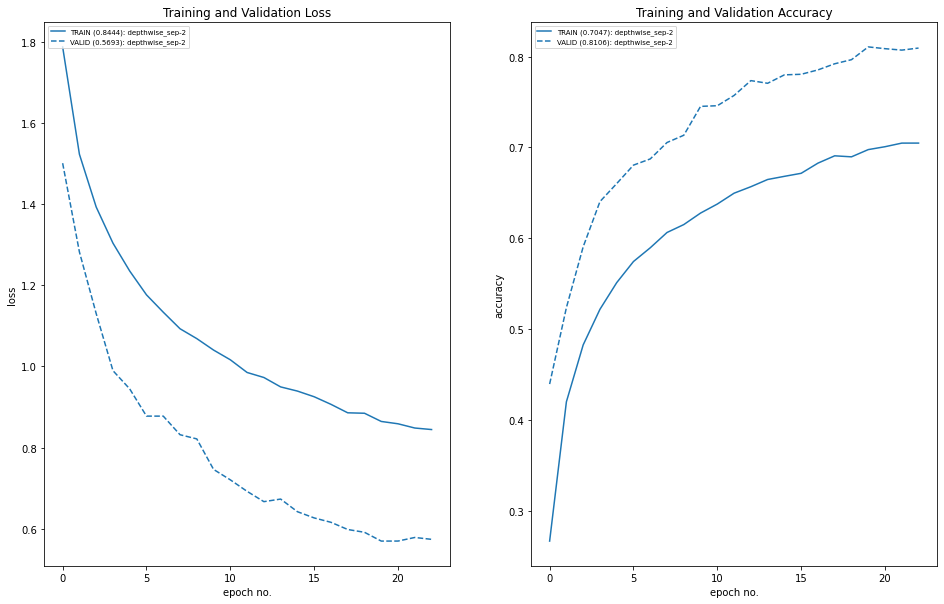

In [35]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["depthwise_sep-2"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)